# Arabic Sign Language Recognition using a Neural Network

## Introduction

This notebook details the implementation of a neural network using PyTorch to recognize Arabic Sign Language alphabets.  The goal is to contribute to improving accessibility and communication for those who use sign language.

## 1. Dataset Details: ArASL

This project utilizes the ArASL (Arabic Alphabets Sign Language Dataset).  This dataset contains images of hand signs representing the Arabic alphabet.

- **Total Images:** 54,049
- **Classes:** 32 (representing the Arabic alphabet)

## 2. Dataset Split

The dataset has been split into training and validation sets:

- **Training Set Size:** 43,239 images
- **Validation Set Size:** 10,810 images

## 3. Label Representation

Each image is associated with a numerical label representing a specific Arabic character.  These labels are integers ranging from 0 to 31.

## 4. Character Mapping

The mapping between numerical labels and corresponding Arabic characters is defined in the `mapping` variable (see code).  The mapping is also provided below for reference:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

## 5. Reference

Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [3]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [4]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:04<00:00, 13.8MB/s]


In [5]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

### If you will build the neural network using numpy, change `t`'s value to 28. If you will build the neural network using pytorch, change `t`'s vlaue to 48. `t`'s value represents the size of the image.

In [6]:
t = 48

## Just run these two cells. You are not supposed to explore them.

In [7]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'ya': 0, 'thaa': 1, 'ra': 2, 'gaaf': 3, 'seen': 4, 'taa': 5, 'laam': 6, 'bb': 7, 'al': 8, 'dhad': 9, 'ain': 10, 'yaa': 11, 'aleff': 12, 'nun': 13, 'kaaf': 14, 'jeem': 15, 'haa': 16, 'waw': 17, 'thal': 18, 'saad': 19, 'meem': 20, 'dha': 21, 'sheen': 22, 'toot': 23, 'dal': 24, 'fa': 25, 'ta': 26, 'zay': 27, 'la': 28, 'ghain': 29, 'khaa': 30, 'ha': 31}


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([

    transforms.Resize((t, t)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [9]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
len(train_dataset), len(val_dataset)

The mapping between the letters and the encoding: 
 {0: 'ya', 1: 'thaa', 2: 'ra', 3: 'gaaf', 4: 'seen', 5: 'taa', 6: 'laam', 7: 'bb', 8: 'al', 9: 'dhad', 10: 'ain', 11: 'yaa', 12: 'aleff', 13: 'nun', 14: 'kaaf', 15: 'jeem', 16: 'haa', 17: 'waw', 18: 'thal', 19: 'saad', 20: 'meem', 21: 'dha', 22: 'sheen', 23: 'toot', 24: 'dal', 25: 'fa', 26: 'ta', 27: 'zay', 28: 'la', 29: 'ghain', 30: 'khaa', 31: 'ha'}


(43239, 10810)

In [10]:
batch_size = 64

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Do Not shuffle validation data

In [11]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 48, 48])

## Let's visualize an image.

The image label: 12 aleff


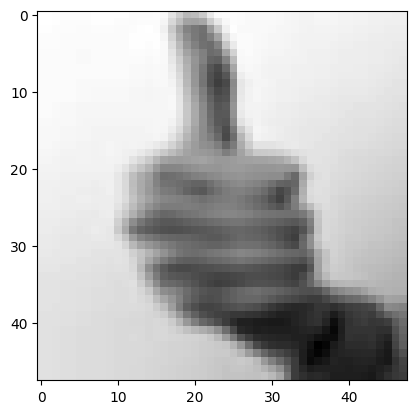

In [12]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

### Instructions:

- Create a Neural Network: Use either PyTorch or NumPy to construct your neural network (NN).
- Train the Model: Once the network is defined, proceed to train the model with the data.
- Experiment with Layers: Adjust and experiment with different layer configurations to optimize the model's performance. Aim to achieve at least 80% accuracy on the validation dataset. Make sure to include a minimum of three distinct layers.
- Explore Activation Functions: Try out various activation functions to find the most effective combination for your network.

### Create a NN uisng Pytorch. Play with the layers to get the best model on the validation data.

In [13]:
import torch.nn.functional as F
class SignLangModel(nn.Module):
  def __init__(self, input_size):
    super(SignLangModel, self).__init__()


    self.linear1 = nn.Linear(input_size, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 128)
    self.linear4 = nn.Linear(128, 64)
    self.linear5 = nn.Linear(64, 32)


  def forward(self, x):

    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = torch.relu(self.linear4(x))
    x = self.linear5(x)

    return x

### Preparing the mdoel and the optimizer.
1. Prepare the device to move the calculations into the GPU.
2. Create the model object that you have defined previously.

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
input_size = 48 * 48
model = SignLangModel(input_size).to(device)

#### Define whatever you need of variables before the training loop.

In [15]:
num_epochs = 15
lr = 1e-3

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr) # Adam is an optimizer (i.e. GD, SGD)
criterion = nn.CrossEntropyLoss()  # multi-class loss.

print(f'Using device {device}')

Using device cuda


#### Train the model and make sure to store the losses of training and validation sets somewhere for later.

1. Create one loop for learninig from the training set.
2. Wrap the training loop by a loop for multiple iterations.
3. After the training loop, add a loop specified for the validaiton set.
4. Compute the accuracy of your model for each iteration.

In [16]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    # We need to flatten the input because it is a 2D array (image) not a linear.
    batch_X = batch_X.view(-1, 48 * 48)

    # Move everything to the device.
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    # predicite over X.
    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    # Compute the loss.
    loss = criterion(batch_y_probs, batch_y)

    # Reset the gradient.
    optimizer.zero_grad()

    # Compute the gradient.
    loss.backward()

    # Update the parameters.
    optimizer.step()

    # Store the loss.
    epoch_weighted_loss += len(batch_y) * loss.item()

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0 # To count the accuracy.

  with torch.no_grad(): # To stop calculating the gradient since we do not need it here.

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.view(-1, 48 * 48)

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        # Predict on val_X
        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)

        val_epoch_weighted_loss += len(val_batch_y) * loss.item()

        # convert probailities to labels by picking the label (index) with the highest prob.
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=3.1510471601695076, val_loss=2.6993633811502518. labelled 1808/10810 correctly (16.725254394079556% accuracy)
Epoch: 1, train_loss=2.4354939520084717, val_loss=2.1407102750915823. labelled 3403/10810 correctly (31.480111008325622% accuracy)
Epoch: 2, train_loss=1.9667848942775465, val_loss=1.8688386193918587. labelled 4287/10810 correctly (39.6577243293247% accuracy)
Epoch: 3, train_loss=1.6710199659628702, val_loss=1.6195273836049406. labelled 5123/10810 correctly (47.391304347826086% accuracy)
Epoch: 4, train_loss=1.4639127534237388, val_loss=1.307711906250046. labelled 6231/10810 correctly (57.64107308048103% accuracy)
Epoch: 5, train_loss=1.2916989098736276, val_loss=1.2761484328957204. labelled 6410/10810 correctly (59.29694727104533% accuracy)
Epoch: 6, train_loss=1.1540144329119126, val_loss=1.0241248260704485. labelled 7324/10810 correctly (67.75208140610546% accuracy)
Epoch: 7, train_loss=0.9984322162315112, val_loss=0.9260648006316581. labelled 7579/10810

#### Plot the training and validation losses.
*HINT: Use the result of the plot to improve your model.*

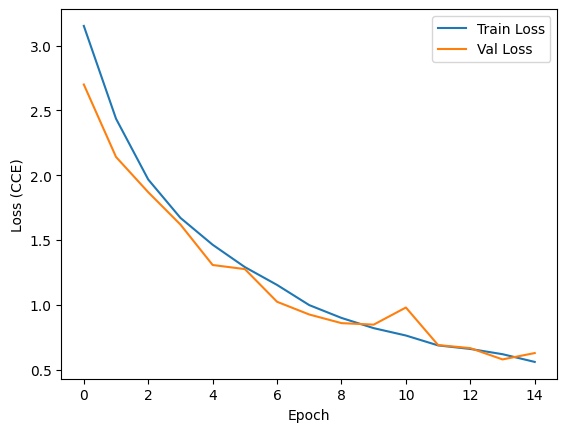

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()